# Processes

The core of idea of latenta is modularization: there are many ways to model single-cell data, but instead of creating several tools and methods for each model, we create a modular interface that can combine and connect the different types of models. While

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import laflow as laf
import numpy as np

We'll use the same dataset as [before](./1-variables).

In [2]:
adata = la.data.load_myod1()

In [3]:
import scanpy as sc

adata.raw = adata

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.combat(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dissociation' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_overexpressed' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'biotype' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [4]:
cellcycle_genes = lac.transcriptome.effects.cellcycle.get_cellcycle_genes()
sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=cellcycle_genes.query("phase == 'S'")["gene"].tolist(),
    g2m_genes=cellcycle_genes.query("phase == 'G2/M'")["gene"].tolist(),
)

In [5]:
adata = adata[adata.obs["phase"] == "G1"].copy()

## Datasets

In [6]:
import tempfile
import pathlib

project_root = pathlib.Path(tempfile.TemporaryDirectory().name)
project_root.mkdir()
laf.set_project_root(project_root)  # sets the default project root

_laflow_ contains two main classes that are used to construct datasets and models:

In [7]:
dataset = laf.Dataset("dataset")

In [8]:
dataset

A dataset contains one or more modalities. In single-cell data, we often use a {class}`laflow.dataset.MatrixModality`, or if we're working with transcriptome data, a {class}`lacell.transcriptome.TranscriptomeModality`:

In [9]:
modality = lac.transcriptome.TranscriptomeModality("transcriptome")

In [10]:
modality

In [11]:
dataset.add_modality(modality)

Dataset now has a transcriptome process, and the transcriptome was added to the "modalities" group:

In [12]:
dataset.transcriptome

In [13]:
dataset

In [14]:
dataset.transcriptome

In [15]:
dataset.transcriptome.from_adata(adata=adata)

▶️ | transcriptome/from_adata                                                                            


✅ | transcriptome/from_adata                                                                            


In [16]:
dataset.transcriptome

## Models

In [17]:
model = laf.Model("model", reset=True)

In [18]:
model.dataset = dataset

In [19]:
model.add_process(lac.transcriptome.Transcriptome())

▶️ | model/create                                                                                        


✅ | model/create                                                                                        


▶️ | model/transcriptome/adapt                                                                           


✅ | model/transcriptome/adapt                                                                           


In [20]:
model.add_process(lac.cell.batch.Batch())

▶️ | model/batch/adapt                                                                                   


✅ | model/batch/adapt                                                                                   


In [21]:
model.add_process(lac.cell.gradient.GradientLatent(label="differentiation"))

▶️ | model/differentiation/adapt                                                                         


✅ | model/differentiation/adapt                                                                         


In [22]:
model.root_initial.plot()

In [23]:
model.transcriptome.add_effect(
    lac.transcriptome.effects.gradient.GradientEffect(gradient=model.differentiation)
)

▶️ | model/transcriptome/differentiation/adapt                                                           


✅ | model/transcriptome/differentiation/adapt                                                           


In [24]:
model.transcriptome.add_effect(
    lac.transcriptome.effects.batch.BatchEffect(batch=model.batch)
)

▶️ | model/transcriptome/batch/adapt                                                                     


✅ | model/transcriptome/batch/adapt                                                                     


In [25]:
model.root_initial.plot()

In [26]:
model.infer()

▶️ | model/create_scheme                                                                                 


✅ | model/create_scheme                                                                                 


▶️ | model/infer                                                                                         


  0%|                                                                                                         …

  0%|                                                                                                         …

✅ | model/infer                                                                                         


In [27]:
model.differentiation.interpret()

▶️ | model/differentiation/interpret                                                                     


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

✅ | model/differentiation/interpret                                                                     


In [28]:
model.transcriptome.differentiation.interpret()

▶️ | model/transcriptome/differentiation/interpret                                                       


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

✅ | model/transcriptome/differentiation/interpret                                                       


In [29]:
adata.obs["differentiation"] = model.differentiation.observed.mean.to_pandas()

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase' as categorical


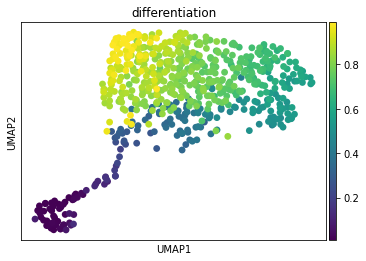

In [30]:
sc.pl.umap(adata, color="differentiation")

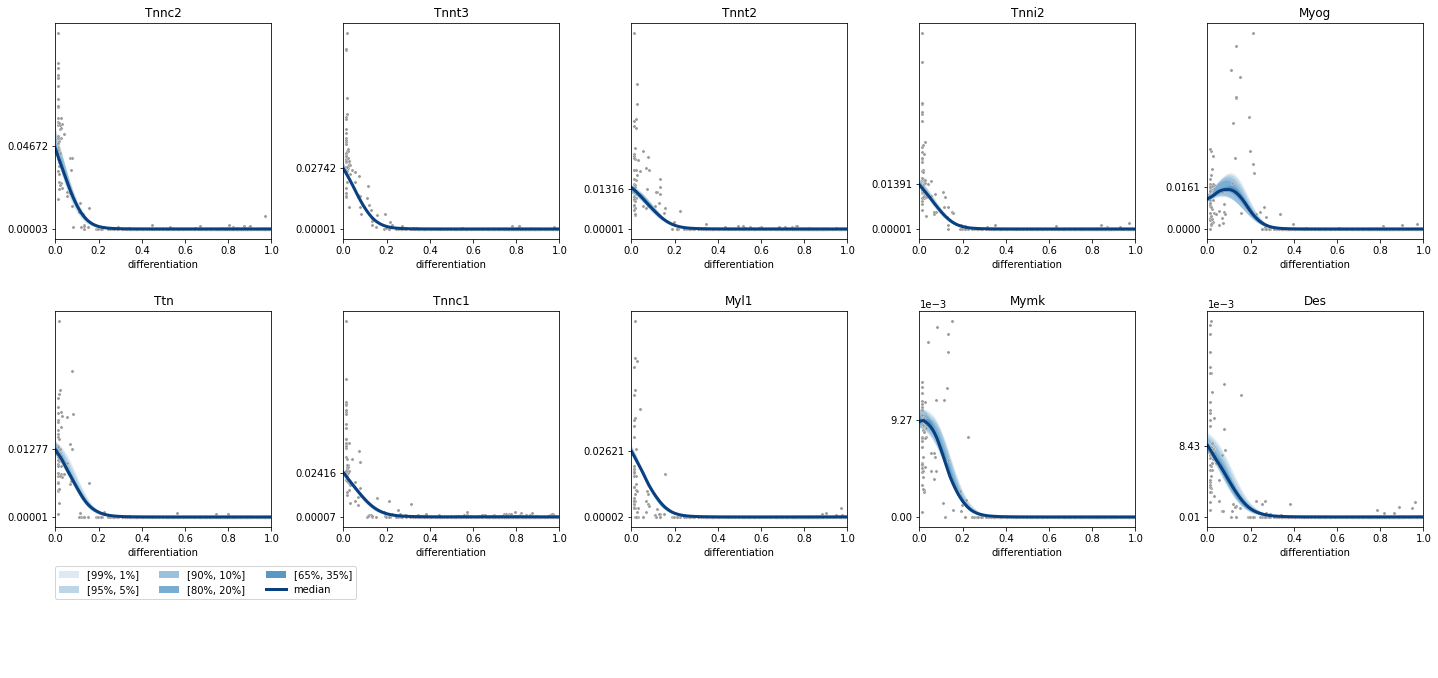

In [31]:
model.transcriptome.differentiation.causal.plot_features()

## Making small manual adjustments

Imagine that you want to use these processes and effect, but just want to make one tiny adjustment. For example, in this case we may want to adjust the prior distribution as we did in the [manifolds](3-manifold) tutorials.

Let's first create the model as before:

In [32]:
model = laf.Model("model_manual_adjustments", dataset=dataset, reset=True)

model.add_process(lac.transcriptome.Transcriptome())

model.add_process(lac.cell.batch.Batch())
model.add_process(lac.cell.gradient.GradientLatent(label="differentiation"))

▶️ | model_manual_adjustments/create                                                                     


✅ | model_manual_adjustments/create                                                                     


▶️ | model_manual_adjustments/transcriptome/adapt                                                        


✅ | model_manual_adjustments/transcriptome/adapt                                                        


▶️ | model_manual_adjustments/batch/adapt                                                                


✅ | model_manual_adjustments/batch/adapt                                                                


▶️ | model_manual_adjustments/differentiation/adapt                                                      


✅ | model_manual_adjustments/differentiation/adapt                                                      


In [33]:
model.transcriptome.add_effect(
    lac.transcriptome.effects.gradient.GradientEffect(gradient=model.differentiation)
)
model.transcriptome.add_effect(
    lac.transcriptome.effects.batch.BatchEffect(batch=model.batch)
)

▶️ | model_manual_adjustments/transcriptome/differentiation/adapt                                        


✅ | model_manual_adjustments/transcriptome/differentiation/adapt                                        


▶️ | model_manual_adjustments/transcriptome/batch/adapt                                                  


✅ | model_manual_adjustments/transcriptome/batch/adapt                                                  


`model.root_initial` contains the full model, but can still be changed before inference. In this case, we want to adjust the prior of the differentiation latent variable.

First, we have to extract this latent variable, and for this you have a couple of options. You can either manually use the the find function to recursively traverse the tree:

```python
model.root_initial.find("differentiation")
```

However, this can cause problems if the model contains named multiple variables with "differentiation" as label. A more direct way is to use the extract function of the process:

In [34]:
gradient = model.differentiation.extract(model.root_initial)

We can now adapt the prior distribution as before:

In [35]:
import pandas as pd

cells = gradient.value_definition["cell"]

gradient_p = la.distributions.Beta(
    beta=la.Fixed(
        pd.Series([1.0, 100.0], index=["Myod1", "mCherry"])[
            adata.obs["gene_overexpressed"]
        ].values,
        definition=[cells],
    ),
    alpha=la.Fixed(
        pd.Series([1.0, 1.0], index=["Myod1", "mCherry"])[
            adata.obs["gene_overexpressed"]
        ].values,
        definition=[cells],
    ),
)
gradient.p = gradient_p

In [36]:
gradient.plot()

In [37]:
model.infer()

▶️ | model_manual_adjustments/create_scheme                                                              


✅ | model_manual_adjustments/create_scheme                                                              


▶️ | model_manual_adjustments/infer                                                                      


  0%|                                                                                                         …

  0%|                                                                                                         …

✅ | model_manual_adjustments/infer                                                                      


In [38]:
model.differentiation.interpret()

▶️ | model_manual_adjustments/differentiation/interpret                                                  


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

✅ | model_manual_adjustments/differentiation/interpret                                                  


In [39]:
model.transcriptome.differentiation.interpret()

▶️ | model_manual_adjustments/transcriptome/differentiation/interpret                                    


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

✅ | model_manual_adjustments/transcriptome/differentiation/interpret                                    


In [40]:
adata.obs["differentiation"] = model.differentiation.observed.mean.to_pandas()

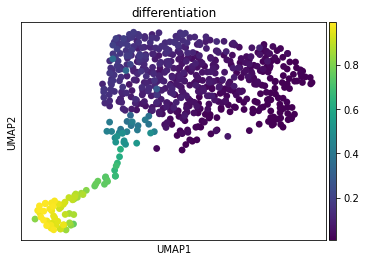

In [41]:
sc.pl.umap(adata, color="differentiation")

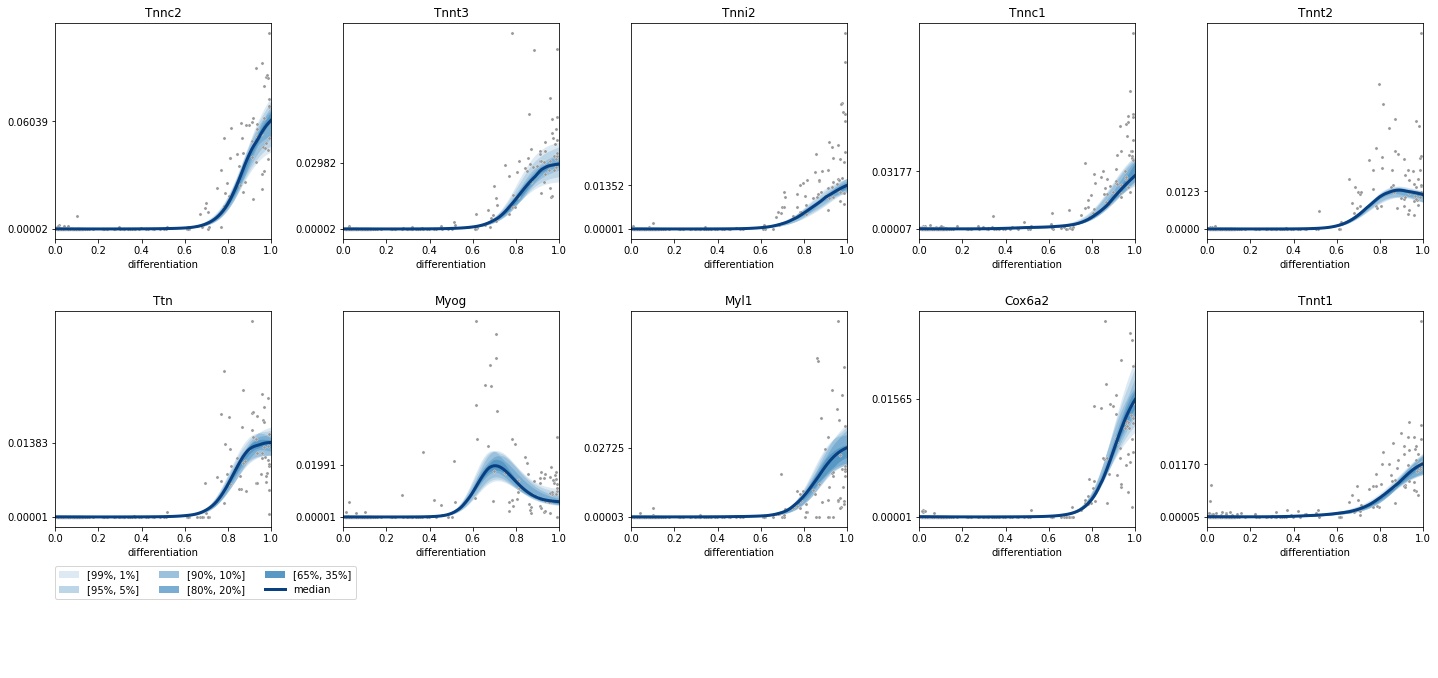

In [42]:
model.transcriptome.differentiation.causal.plot_features()

## Custom processes

To make things easier to maintain and modularize, we can put our adaptations inside a subclass of {class}`lacell.cell.gradient.GradientLatent`. The

In [43]:
class DifferentiationLatent(lac.cell.gradient.GradientLatent):
    label = laf.PyObj(default=lambda: "differentiation")

    parent = lac.cell.gradient.GradientLatent.parent

    @lac.cell.gradient.GradientLatent.adapt.extend()
    def adapt(self, output, root_initial, obs, **kwargs):
        # call super adapt function
        output = super().adapt_(
            output=output, root_initial=root_initial, obs=obs, **kwargs
        )
        gradient = self.extract(root_initial)

        cells = gradient.value_definition["cell"]

        import pandas as pd

        gradient_p = la.distributions.Beta(
            beta=la.Fixed(
                pd.Series([1.0, 100.0], index=["Myod1", "mCherry"])[
                    obs["gene_overexpressed"]
                ].values,
                definition=[cells],
            ),
            alpha=la.Fixed(
                pd.Series([1.0, 1.0], index=["Myod1", "mCherry"])[
                    obs["gene_overexpressed"]
                ].values,
                definition=[cells],
            ),
        )
        gradient.p = gradient_p

        output.root_initial = root_initial

        return output

In [44]:
model = laf.Model("model_custom_process", dataset=dataset, reset=True)

In [45]:
model.add_process(lac.transcriptome.Transcriptome())

model.add_process(lac.cell.batch.Batch())
model.add_process(DifferentiationLatent())

▶️ | model_custom_process/create                                                                         


✅ | model_custom_process/create                                                                         


▶️ | model_custom_process/transcriptome/adapt                                                            


✅ | model_custom_process/transcriptome/adapt                                                            


▶️ | model_custom_process/batch/adapt                                                                    


✅ | model_custom_process/batch/adapt                                                                    


▶️ | model_custom_process/differentiation/adapt                                                          


✅ | model_custom_process/differentiation/adapt                                                          


In [46]:
model.transcriptome.add_effect(
    lac.transcriptome.effects.gradient.GradientEffect(gradient=model.differentiation)
)
model.transcriptome.add_effect(
    lac.transcriptome.effects.batch.BatchEffect(batch=model.batch)
)

▶️ | model_custom_process/transcriptome/differentiation/adapt                                            


✅ | model_custom_process/transcriptome/differentiation/adapt                                            


▶️ | model_custom_process/transcriptome/batch/adapt                                                      


✅ | model_custom_process/transcriptome/batch/adapt                                                      


In [47]:
model.root_initial.plot()

In [48]:
model.infer()

▶️ | model_custom_process/create_scheme                                                                  


✅ | model_custom_process/create_scheme                                                                  


▶️ | model_custom_process/infer                                                                          


  0%|                                                                                                         …

  0%|                                                                                                         …

✅ | model_custom_process/infer                                                                          


In [49]:
model.differentiation.interpret()

▶️ | model_custom_process/differentiation/interpret                                                      


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

✅ | model_custom_process/differentiation/interpret                                                      


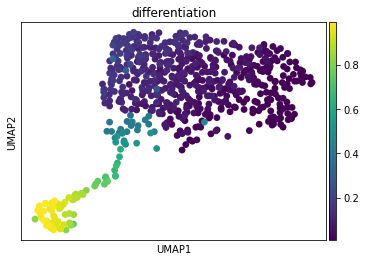

In [50]:
adata.obs["differentiation"] = model.differentiation.observed.mean.to_pandas()
sc.pl.umap(adata, color="differentiation")

## Custom effects

{class}`~lac.transcriptome.effects.gradient.GradientEffect` uses a spline function by default, but maybe we want to use a simpler linear function:

In [51]:
class DifferentiationEffect(lac.transcriptome.effects.gradient.GradientEffect):
    @lac.transcriptome.effects.gradient.GradientEffect.adapt.extend()
    def adapt(self, output, root_initial, **kwargs):
        # extract gradient and foldchange
        gradient = self.gradient.extract(root_initial)
        foldchange = self.parent.extract_foldchange(root_initial)

        # add effect to foldchange
        effect = la.links.scalar.Switch(
            gradient, a=True, switch=True, definition=foldchange.value_definition
        )
        setattr(foldchange, self.label, effect)

        output.root_initial = root_initial

        return output

In [52]:
model = laf.Model("model_custom_effect", dataset=dataset, reset=True)

In [53]:
model.add_process(lac.transcriptome.Transcriptome())

model.add_process(lac.cell.batch.Batch())
model.add_process(DifferentiationLatent())

▶️ | model_custom_effect/create                                                                          


✅ | model_custom_effect/create                                                                          


▶️ | model_custom_effect/transcriptome/adapt                                                             


✅ | model_custom_effect/transcriptome/adapt                                                             


▶️ | model_custom_effect/batch/adapt                                                                     


✅ | model_custom_effect/batch/adapt                                                                     


▶️ | model_custom_effect/differentiation/adapt                                                           


✅ | model_custom_effect/differentiation/adapt                                                           


In [54]:
model.transcriptome.add_effect(DifferentiationEffect(gradient=model.differentiation))
model.transcriptome.add_effect(
    lac.transcriptome.effects.batch.BatchEffect(batch=model.batch)
)

▶️ | model_custom_effect/transcriptome/differentiation/adapt                                             


✅ | model_custom_effect/transcriptome/differentiation/adapt                                             


▶️ | model_custom_effect/transcriptome/batch/adapt                                                       


✅ | model_custom_effect/transcriptome/batch/adapt                                                       


In [55]:
model.root_initial.plot()

In [56]:
model.infer()

▶️ | model_custom_effect/create_scheme                                                                   


✅ | model_custom_effect/create_scheme                                                                   


▶️ | model_custom_effect/infer                                                                           


  0%|                                                                                                         …

  0%|                                                                                                         …

✅ | model_custom_effect/infer                                                                           


In [57]:
model.differentiation.interpret()

▶️ | model_custom_effect/differentiation/interpret                                                       


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

✅ | model_custom_effect/differentiation/interpret                                                       


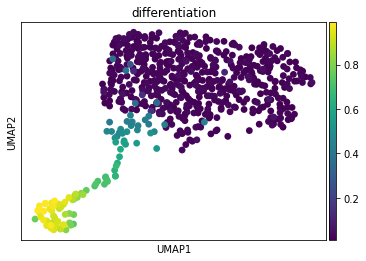

In [58]:
adata.obs["differentiation"] = model.differentiation.observed.mean.to_pandas()
sc.pl.umap(adata, color="differentiation")

In [59]:
model.transcriptome.differentiation.interpret()

▶️ | model_custom_effect/transcriptome/differentiation/interpret                                         


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

✅ | model_custom_effect/transcriptome/differentiation/interpret                                         


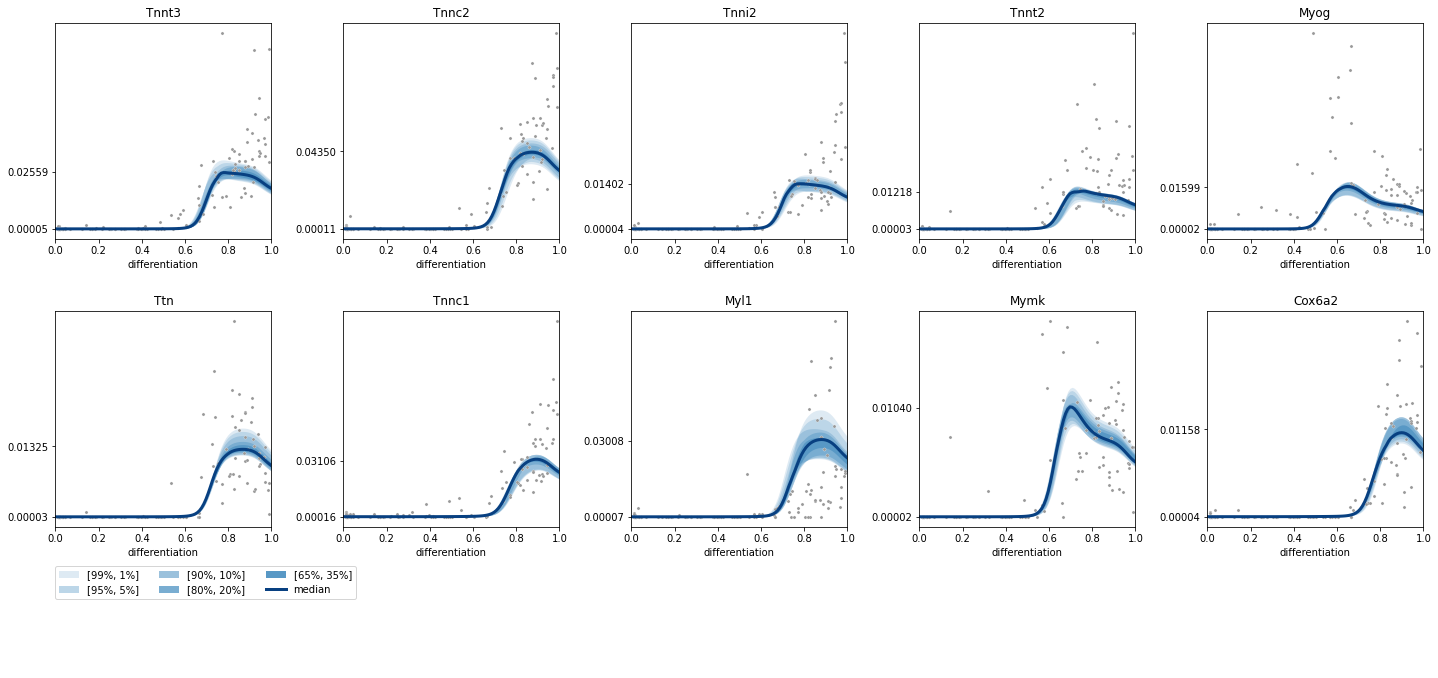

In [60]:
model.transcriptome.differentiation.causal.plot_features()